<a href="https://colab.research.google.com/github/hyunlimy/ECG_arrhythmia/blob/main/ecg_detection_kosaim21_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoSAIM 2021 춘계학술대회 <br> Hands-On Session II <br>생체 신호 분석의 실제 - (2) 심전도 분석 
- May. 21, 2021
- Author : **Hyun-Lim Yang, Ph.D.**<br>
Research Assistant Professor @
Seoul National University Hospital
- E-mail : hly{_at_}snuh{_dot_}org
***


## 0. Goal
#### Heart Arrhythmia Detection from ECG waveform with Deep  Learning model
본 강의에서는 **딥러닝을 이용해서 ECG waveform을 분석하고 arrhythmia를 예측하는 방법**을 알아봅니다.<br>
아래의 온라인 자료들을 활용하여 더 많은 정보를 확인할 수 있습니다.<br>
(본 강의도 아래 자료의 일부 내용을 참고하였습니다.)<br>
>Reference source: <br>
> https://github.com/andrewwlong/deep_arrhythmias <br>
> https://towardsdatascience.com/detecting-heart-arrhythmias-with-deep-learning-in-keras-with-dense-cnn-and-lstm-add337d9e41f <br>
> https://github.com/eddymina/ECG_Classification_Pytorch/blob/master/ECG_notebook.ipynb <br>
***

## 1. Backgrounds
### 1-1. Dataset
**MIT-BIH Arrhythmia dataset**을 활용하여 실습을 진행합니다. <br>
(source: https://physionet.org/content/mitdb/1.0.0/) <br>
이 데이터셋은 Boston's Beth Israel Hospital 에서 1975년 ~ 1979년 사이 in-patient & out-patient를 모두 포함하는 4000명 환자의 case에서, **23개 case를 랜덤 샘플**하고 **중요한 arrhythmia를 포함하는 25개 case를 임의로 선택**하여 구축하였습니다.<br>
360Hz를 가지는 2-channel ECG waveform과 annotation을 포함합니다.

### 1-2. Deep Learning Framework 
본 실습에서는 **`Pytorch`**를 활용합니다. (official site: https://pytorch.org/)<br>
`Pytorch`는 Facebook에서 개발한 open source deep learning framework로써 Tensorflow, Keras, Caffe, MXNet 등과 함께 많이 쓰이는 프레임워크 입니다.<br>
특히 `Pytorch`는 python으로 데이터 분석을 수행할 때 많이 쓰이는 **`numpy` 등과 호환성이 좋고** 딥러닝 모델 **개발의 자유도가 높아**서 인공지능 연구자들 사이에서 인기가 높습니다. <br>
Tensorflow과 달리 compile 과정이 없이 직관적으로 중간 연산 결과를 확인할 수 있어 딥러닝 모델을 쉽게 이해하고 수정직후 결과를 확인할 수 있습니다.

### 1-3. Other packages
이외에 사용되는 주요한 패키지는 다음과 같습니다:
1. `wfdb` : MIT-BIH arrhythmia dataset을 배포하는 MIMIC 팀이 자체 데이터를 처리하기 위해 개발하고 배포하는 패키지 입니다. signal과 annotation data를 읽어오는데 사용합니다.
2. `numpy` : 벡터, 행렬 연산에 특화된 패키지 입니다.
3. `pandas` : 데이터 분석에 특화된 패키지 입니다. 데이터 전처리와 후처리에 활용합니다.
4. `matplotlib` : Data visualization에 특화된 패키지 입니다. 각종 plotting에 활용합니다.
5. `sklearn` : 기계학습에 특화된 패키지 입니다. 모델 성능 분석에 활용합니다.


***

## 2. Data Downloads and Basic Statistics

In [ ]:
!pip install wfdb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import os
import sys
import glob
import tqdm
import random
from itertools import cycle
import warnings
warnings.filterwarnings(action='ignore')

import wfdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.preprocessing import label_binarize

### 2.1 Data download
실습에 사용될 데이터를 다운받습니다.<br>
데이터 사이즈가 크지 않으므로 로컬로 mimic 홈페이지에서 바로 다운로드를 진행합니다<br>
> **Warning!** <br>
> 만약, 데이터 다운로드에 너무 오랜 시간이 걸리거나 오류가 있다면, 아래의 공유 링크를 클릭하여 '나의 드라이브에 바로가기 추가'를 하고, comment out한 코드를 실행시키세요. <br>
> Link: https://drive.google.com/drive/folders/1GJJXU5VFAG1nJVeYX-Yy3a2kbaYwuDq3?usp=sharing

In [ ]:
!wget https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip mit-bih-arrhythmia-database-1.0.0.zip

download_directory = os.getcwd()
sys.path.append(download_directory)
os.listdir(download_directory)

['mit-bih-arrhythmia-database-1.0.0.zip',
 '.ipynb_checkpoints',
 'Kosaim2021_ecg_detection_hands_on_hlyang.ipynb',
 'data',
 'mit-bih-arrhythmia-database-1.0.0',
 'Untitled.ipynb']

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# cloud_directory = '/content/gdrive/My Drive/mit_bih_arrhythmia/'
# download_directory = cloud_directory
# os.listdir(cloud_directory)

### 2-2. Data loading and basic statistics
데이터는 48개 케이스로 구성되고 각 케이스는 `hea`, `atr`, `dat`, `xws` 파일로 구성되어 있습니다.<br>
annotation 관련 정보는 `atr` 파일에 포함되어 있습니다.<br>
`wfdb` 패키지의 `rdann` 함수를 사용하여 `atr` 파일 내의 annotation을 불러올 수 있습니다.

In [ ]:
# datapath
datapath = './mit-bih-arrhythmia-database-1.0.0/'
# mimic dataset 파일 구성: hea, atr, dat, xws
print(os.listdir(datapath))

['117.xws', '209.hea', '107.xws', 'x_mitdb', '214.dat', '217.dat', '115.dat', '210.hea', '106.atr', '217.atr', '108.hea', '112.xws', '115.xws', '223.dat', '107.hea', '213.xws', '223.hea', '112.dat', '113.hea', '104.hea', '102-0.atr', '205.atr', '106.xws', '103.hea', '124.dat', '108.dat', '202.atr', '231.dat', '217.hea', '234.xws', '103.xws', '117.at_', '104.atr', '118.atr', '121.dat', '122.xws', '234.dat', '221.xws', '205.hea', '222.atr', '105.dat', '108.atr', '111.xws', '203.atr', '202.hea', '107.atr', '113.dat', '233.xws', '231.atr', '212.xws', '124.atr', '105.atr', 'ANNOTATORS', '213.dat', 'mitdbdir', '101.dat', '208.hea', '220.dat', '200.hea', '234.atr', '203.hea', '209.xws', '205.xws', '228.hea', '118.dat', '208.atr', '220.atr', '115.atr', '212.hea', '105.xws', '201.atr', '123.xws', '119.at_', '213.hea', '201.xws', '118.hea', '116.atr', '112.atr', '122.dat', '215.dat', '210.dat', '102.dat', '101.atr', '232.dat', '212.dat', '109.xws', '102.hea', '119.xws', '200.atr', '203.at_', '11

데이터에서 환자번호를 뽑아옵니다.

In [ ]:
header_files = [os.path.basename(x) for x in glob.glob(os.path.join(datapath, '*.hea'))]
pids = sorted([x.split('.')[0] for x in header_files])

In [ ]:
# annotation 파일 불러와서 label의 분포 확인
df = pd.DataFrame()

for pid in pids:
    file = os.path.join(datapath, pid)
    annotation = wfdb.rdann(os.path.join(file), 'atr')
    symbols = annotation.symbol
    
    values, cnts = np.unique(symbols, return_counts=True)
    df_sub = pd.DataFrame({'symbol': values, 'value': cnts, 'pid':[pid] * len(cnts)})
    df = pd.concat([df, df_sub], axis=0)

대부분의 annotation은 `N` symbol, 즉 정상 beat annotation을 가지고 있습니다.

In [ ]:
# Annotation 파일의 분포
df.groupby('symbol').value.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: value, dtype: int64

MIT-BIH arrhythmia dataset에 포함되는 모든 annotation은 다음과 같습니다.<br>
보다 자세한 내용은 아래 공식 홈페이지에서 확인할 수 있습니다.<br>

> reference: <br> 
> https://www.physionet.org/physiobank/database/html/mitdbdir/tables.htm

Beat annotations:<br>

|Code	|	Description    |
| :-: | :- |
| N	|	Normal beat <br>(displayed as "·" by the PhysioBank ATM, LightWAVE, pschart, and psfd)|
|L	|	Left bundle branch block beat |
|R	|	Right bundle branch block beat |
|B	|	Bundle branch block beat (unspecified) |
|A	|	Atrial premature beat |
|a	|	Aberrated atrial premature beat |
|J	|	Nodal (junctional) premature beat |
|S	|	Supraventricular premature or ectopic beat (atrial or nodal) |
|V	|	Premature ventricular contraction |
|r	|	R-on-T premature ventricular contraction |
|F	|	Fusion of ventricular and normal beat |
|e	|	Atrial escape beat |
|j	|	Nodal (junctional) escape beat |
|n	|	Supraventricular escape beat (atrial or nodal) |
|E	|	Ventricular escape beat |
|/	|	Paced beat |
|f	|	Fusion of paced and normal beat |
|Q	|	Unclassifiable beat |
|?	|	Beat not classified during learning |

Non-beat annotations:<br>

|Code	|	Description|
| :-: | :- |
|\[	|	Start of ventricular flutter/fibrillation |
|!	|	Ventricular flutter wave |
|\]	|	End of ventricular flutter/fibrillation |
|x	|	Non-conducted P-wave (blocked APC) |
|(	|	Waveform onset |
|)	|	Waveform end |
|p	|	Peak of P-wave |
|t	|	Peak of T-wave |
|u	|	Peak of U-wave |
|\`	|	PQ junction |
|'	|	J-point |
|^	|	(Non-captured) pacemaker artifact |
||	|	Isolated QRS-like artifact |
|~	|	Change in signal quality |
|+	|	Rhythm change |
|s	|	ST segment change |
|T	|	T-wave change |
|*	|	Systole |
|D	|	Diastole |
|=	|	Measurement annotation |
|"	|	Comment annotation |
|@	|	Link to external data |



본 강좌에서는 non-beat annotation은 모두 무시하고, 정상과 비정상 beat만 구분하여 arrhythmia를 detect 할 수 있는 딥러닝 모델을 만들어 보겠습니다.

In [ ]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [ ]:
# normal, abnormal, nonbeat의 비율 구성 확인
df['type'] = -1 # nonbeat
df.loc[df.symbol == 'N', 'type'] = 0 # normal
df.loc[df.symbol.isin(abnormal), 'type'] = 1 # abnormal

In [ ]:
df.groupby('type').value.sum()

type
-1     3186
 0    75052
 1    34409
Name: value, dtype: int64

#### Define ECG data loading function
`wfdb` 패키지를 이용하여 ECG waveform과 annotation을 불러올 수 있는 함수를 정의합니다.<br>
`rdrecord` 함수를 이용하여 raw signal 데이터를 불러옵니다 <br>
`rdann` 함수를 이용하여 annotation 데이터의 symbol 과 symbol의 index를 불러옵니다.

In [ ]:
# load single patient's ecg signal and annotation
def load_ecg(file):
    """
    wfdb.rdrecord 를 이용해서 ecg 파일을 읽어옵니다.
    """
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_index = annotation.sample
    
    return p_signal, atr_sym, atr_index

예시로 신호 데이터의 일부를 plotting 해보면 다음과 같습니다.<br>
여기서, 각 변수는 다음을 의미합니다. <br>
`p_signal` = raw ecg signal <br>
`atr_sym` = annotation symbol <br>
`atr_sample` = annotation index <br>

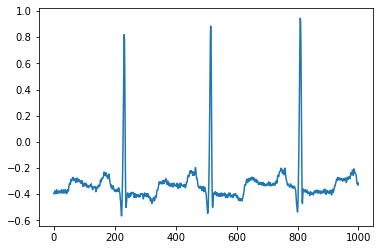

In [ ]:
file = os.path.join(datapath, pids[0])
p_signal, atr_sym, atr_sample = load_ecg(file)
plt.plot(p_signal[1000:2000, 0])

이 환자 케이스에서 가지고 있는 annotation을 살펴보면 다음과 같습니다.

In [ ]:
values, counts = np.unique(atr_sym, return_counts = True)
for v, c in zip(values, counts):
    print(v, c)

+ 1
A 33
N 2239
V 1


이 중 abnormal에 해당되는 annotation의 위치를 살펴보면 다음과 같습니다.

In [ ]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

위의 abnormal에 해당되는 annotation의 index를 기준으로, 전후 3초의 ecg signal을 plotting 해보면 다음과 같습니다. 

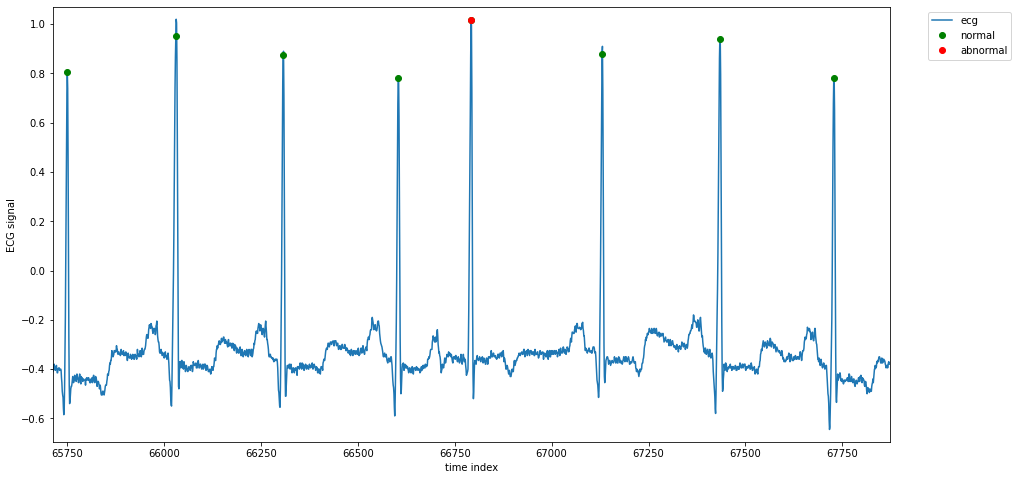

In [ ]:
x = np.arange(len(p_signal))
left = ab_index[1]-(360*3) # 전 3초
right = ab_index[1]+(360*3) # 후 3초

plt.figure(figsize=(15, 8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

***

## 3. Preparing dataset for deep learning

### 3-1. Define functions to build dataset for deep learning
이제 본격적으로 딥러닝에 사용할 데이터셋을 구축 해보겠습니다.<br>
데이터셋 구축 방법은 딥러닝 모델의 구조와 추후 모델 활용 방식에 따라 여러가지가 있을 수 있습니다.<br>
본 강의에서는 `n`초의 raw signal waveform내에 arrhythmia를 포함하는지 아닌지를 detect 할 수 있는 딥러닝 모델을 만들어 보겠습니다.<br>
annotation 된 index를 기준으로, 전 후 `n/2`초의 raw signal을 하나의 segment로 자르고 그에 상응하는 annotation symbol을 label로 지정하여 데이터셋을 구축하겠습니다.<br>
<br>
우선 non-beat annotation을 제외하고 normal symbol과 abnormal symbol의 index만 추출합니다.<br>
추출된 annotation index를 기준으로 순회하며 abnormal symbol인 경우는 `Y` 값에 `1`을 할당하고, normal beat는 `0`을 할당합니다.<br>
또한 대응되는 annotation symbol을 별도로 추출하여 `symbol`값에 할당합니다.

In [ ]:
def build_dataset(pids, window_size, freq, abnormal):
    """
    딥러닝 모델 학습을 위한 데이터를 구축합니다.
    """
    ncols = window_size * freq
    X_merged = np.zeros((1, ncols))
    Y_merged = np.zeros((1,1))
    symbol_merged = []
    
    rows_per_pid = []
    
    for pid in tqdm.tqdm(pids):
        
        filename = datapath + pid
        p_signal, atr_sym, atr_sample = load_ecg(filename)
        
        p_signal = p_signal[:,0]
        
        # beat index (exclude non-beat)
        beat_annotation_index = [x in (abnormal + ['N']) for x in atr_sym]
        
        X, Y, symbols = build_XY(signal=p_signal, 
                                 atr_sym = atr_sym, 
                                 atr_sample = atr_sample,
                                 beat_index = beat_annotation_index, 
                                 nsec = window_size/2, 
                                 fs = freq,
                                 ncols = ncols,
                                 abnormal = abnormal)
        
        X_merged = np.append(X_merged, X, axis=0)
        Y_merged = np.append(Y_merged, Y, axis=0)
        symbol_merged = symbol_merged + symbols
        rows_per_pid.append(Y.shape[0])
        
    # drop first zero rows
    X_merged = X_merged[1:,:]
    Y_merged = Y_merged[1:,:]
    
    # check sizes make sense
    assert np.sum(rows_per_pid) == X_merged.shape[0], 'number of X, max_rows rows messed up'
    assert Y_merged.shape[0] == X_merged.shape[0], 'number of X, Y rows messed up'
    assert Y_merged.shape[0] == len(symbol_merged), 'number of Y, sym rows messed up'
    
    return X_merged, Y_merged, symbol_merged


def build_XY(signal, atr_sym, atr_sample, beat_index, nsec, fs, ncols, abnormal):
    """
    하나의 환자 id에서 signal과 annotation을 추출합니다.
    """
    
    num_rows = len(beat_index)

    X = np.zeros((num_rows, ncols))
    Y = np.zeros((num_rows,1))
    symbols = []
    
    # keep track of rows
    max_row = 0
    
    beat_atr_sym = np.array(atr_sym)[beat_index]
    beat_atr_sample = np.array(atr_sample)[beat_index]

    for sym, samp in zip(beat_atr_sym, beat_atr_sample):

        left = int(max([0,(samp - nsec*fs) ]))
        right = int(min([len(signal),(samp + nsec*fs) ]))
        
        x = signal[left: right]
        if len(x) == ncols:
            X[max_row,:] = x
            Y[max_row,:] = int(sym in abnormal)
            symbols.append(sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X, Y, symbols

### 3-2. Build train and validation dataset
train과 validation에 사용할 데이터셋을 각각 구축합니다.<br>
일반적인 딥러닝 학습시에는 다음과 같이 데이터를 구축합니다.<br>
1. `train dataset`
2. `validation dataset`
3. `test dataset`

`train dataset`은 딥러닝 모델 학습에 사용되고, <br>
`validation dataset`은 딥러닝 학습 시 overfitting 등을 검증하는데 활용되고,<br>
`test dataset`은 딥러닝 모델 평가에 활용됩니다.<br>
<br>
본 강의에서는 편의상 `train dataset` 과 `validation dataset` 만 구축하여 모델을 학습하고 그 과정을 확인해보겠습니다. <br>
<br>
<font color='darkred'>여기서 주의할점은</font>, **case 기준으로 train과 validation을 구분해야 한다는 것**입니다.<br>
case를 구분하지 않고 전체 sample에서 random하게 train/validation을 구분할 경우 딥러닝 모델의 성능은 우수한 것으로 나올 수 있지만 실제 성능은 (training data이외의 데이터에서 평가시) 성능이 떨어지는 경우가 발생할 수 있습니다.<br>


In [ ]:
# 6초의 segment로 데이터 구축
window_size = 6
frequency = 360
batch_size = 1000

In [ ]:
# dataset split
random.seed(77)
pids_valid = random.sample(pids, int(len(pids) / 4))
pids_train = [pid for pid in pids if pid not in pids_valid]

In [ ]:
# build dataset
X_train, Y_train, symbol_train = build_dataset(pids_train, 
                                               window_size, 
                                               frequency, 
                                               abnormal)
X_valid, Y_valid, symbol_valid = build_dataset(pids_valid,
                                              window_size,
                                              frequency,
                                              abnormal)

print("Shape of train dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_train.shape, Y_train.shape, len(symbol_train)))
print("Shape of valid dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_valid.shape, Y_valid.shape, len(symbol_valid)))

100%|██████████| 12/12 [00:01<00:00,  6.17it/s]

Shape of train dataset: 
 X: (82168, 2160) 
 Y: (82168, 1) 
 symbol: 82168 

Shape of valid dataset: 
 X: (26931, 2160) 
 Y: (26931, 1) 
 symbol: 26931 



In [ ]:
# train / validation symbol 확인
print(np.unique(symbol_train))
print(np.unique(symbol_valid))

['/' 'A' 'E' 'F' 'J' 'L' 'N' 'R' 'S' 'V' 'a' 'e' 'f' 'j']
['/' 'A' 'F' 'L' 'N' 'R' 'V' 'a' 'j']


In [ ]:
# train과 validation의 abnormal 비율 확인
print('{:.3f} %'.format((Y_train.sum() / len(Y_train))* 100))
print('{:.3f} %'.format((Y_valid.sum() / len(Y_valid))* 100))

30.569 %
34.109 %


#### Prepare DataLoader
`Pytorch`는 데이터를 불러오는 과정을 쉽게 해주는 함수들을 제공합니다.<br>
사전 정의된 `Dataset` 클래스를 상속하여 custom dataset을 만들고 `DataLoader`를 이용해 데이터를 불러와주는 `generator`를 만듭니다.

In [ ]:
class MyEcgDataset(Dataset):
    
    def __init__(self, data, labels, symbols):
        super().__init__()
        self.data = data
        self.labels = labels
        self.symbol = symbols
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.symbol[idx]

In [ ]:
train_dataset = MyEcgDataset(X_train, Y_train, symbol_train)
valid_dataset = MyEcgDataset(X_valid, Y_valid, symbol_valid)

train_generator = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_generator = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

***

## 4. Deep Learning model training - binary classification

첫번째 예제로 binary classification (이진분류) 을 수행해 보겠습니다.<br>
아주 단순한 Artificial Neural Network 모델을 사용할 것입니다.<br>
딥러닝 모델의 예측 결과가 0인 경우 normal beat 에 해당되고 1인 경우 abnormal에 해당합니다.<br>



### 4-1. Define training function
이진 분류를 위해서 모델 output에 `sigmoid` 함수를 취합니다.<br>
각 epoch 마다 validation 결과를 출력하고 전체 loss 변화를 plotting 합니다.

In [ ]:
def train_binary(model, lr, epoch, criterion, optimizer, scheduler, 
          _train_generator, _valid_generator, use_scheduler = False):

    # for loss plotting
    train_loss_log = []
    valid_loss_log = []

    for epo in range(epoch):

        for step, (batch_X, batch_Y, batch_samp) in enumerate(_train_generator):
            model.zero_grad()
            optimizer.zero_grad()
            batch_X = batch_X.to('cuda:0')
            batch_Y = batch_Y.to('cuda:0')

            model.train()
            output = model(batch_X.float())
            loss = criterion(output, batch_Y.reshape(-1, 1).float())
            loss.backward()
            optimizer.step()

            training_loss = loss.data.cpu().numpy().astype(float)

            if step % 50 == 0:
                print('[Epochs: ' + str(epo+1) + '  step: ' + str(step) + 
                      ']' + '  Train loss: {:.4f}'.format(training_loss))
        
        if use_scheduler:
            scheduler.step()
                
        # validation
        model.eval()
        valid_output = []
        valid_target = []
        valid_pred = []

        for valid_x, valid_y, _ in _valid_generator:
            valid_x = valid_x.to('cuda:0')
            
            val_out = model(valid_x.float())
            val_pred = F.sigmoid(val_out)
            
            val_out = val_out.cpu().data.numpy().astype(float)
            val_pred = val_pred.cpu().data.numpy().astype(float)

            valid_output.extend(val_out)
            valid_target.extend(valid_y)
            valid_pred.extend(val_pred)

        valid_output_var = torch.from_numpy(np.array(valid_output)).float()
        valid_target_var = torch.from_numpy(np.array(valid_target)).float()
        valid_pred_var = torch.from_numpy(np.array(valid_pred)).float()

        valid_loss = criterion(valid_output_var, valid_target_var.reshape(-1, 1))
        valid_output_np = valid_output_var.reshape(-1).detach().numpy().round()
        valid_target_np = valid_target_var.reshape(-1).detach().numpy().round()
        valid_pred_np = valid_pred_var.reshape(-1).detach().numpy().round()

        validation_loss = valid_loss.data.cpu().numpy().astype(float)
        accuracy = (valid_pred_np == valid_target_np).mean()

        print('[Epoch {} ends --------------------------]'.format(epo+1))
        print('Current lr: {}'.format(optimizer.param_groups[0]['lr']))
        print('Validation loss : {:.4f}  /  Accuracy : {:.3f} \n'.format(
        valid_loss, accuracy * 100))

        # for log plotting
        train_loss_log.append(training_loss)
        valid_loss_log.append(validation_loss)

    training_log_df = pd.DataFrame({'train_loss': train_loss_log, 
                                   'valid_loss': valid_loss_log})
    df_fig_loss = training_log_df.astype(float).plot(
        ylim=(0, max(np.concatenate([training_log_df.train_loss.values, training_log_df.valid_loss.values])) * 1.2))
    
    return valid_pred_np, valid_target_np 

### 4-2. Define Fully Connected Network
아주 간단한 딥러닝 모델을 정의합니다.<br>
우선 다른 모듈을 사용하지 않고 단순한 linear layer 2개층을 가지는 네트워크를 생성해보겠습니다.<br>
모델의 input은 2160 sized raw waveform (360\*6=2160)이고 중간에 512개와 128개의 neuron을 갖는 layer를 하나 가지고 있는 단순한 네트워크 입니다.<br>
또한 모델 초기화를 위한 함수를 추가합니다.

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.)
    
    elif type(m) == nn.Conv1d:
        nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
class simple_FCN(nn.Module):
    def __init__(self):
        super(simple_FCN, self).__init__()
        
        self.fc0 = nn.Linear(2160, 512)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

### 4-3. Train model
모델을 학습시킵니다.<br>
앞서 정의한 네트워크를 선언하고 초기화합니다.<br>
학습을 위한 loss function은 `Binary Cross Entropyloss`를 사용하고 optimizer는 `Adam`을 사용합니다.

[Epochs: 1  step: 0]  Train loss: 0.7186
[Epochs: 1  step: 50]  Train loss: 0.4118
[Epoch 1 ends --------------------------]
Current lr: 0.0001
Validation loss : 0.4978  /  Accuracy : 77.071 

[Epochs: 2  step: 0]  Train loss: 0.3222
[Epochs: 2  step: 50]  Train loss: 0.3148
[Epoch 2 ends --------------------------]
Current lr: 0.0001
Validation loss : 0.4409  /  Accuracy : 78.872 

[Epochs: 3  step: 0]  Train loss: 0.2240
[Epochs: 3  step: 50]  Train loss: 0.2380
[Epoch 3 ends --------------------------]
Current lr: 0.0001
Validation loss : 0.4412  /  Accuracy : 78.853 

[Epochs: 4  step: 0]  Train loss: 0.2047
[Epochs: 4  step: 50]  Train loss: 0.1699
[Epoch 4 ends --------------------------]
Current lr: 0.0001
Validation loss : 0.4052  /  Accuracy : 80.331 

[Epochs: 5  step: 0]  Train loss: 0.1462
[Epochs: 5  step: 50]  Train loss: 0.1658
[Epoch 5 ends --------------------------]
Current lr: 1e-05
Validation loss : 0.4028  /  Accuracy : 80.368 

[Epochs: 6  step: 0]  Train loss: 0.

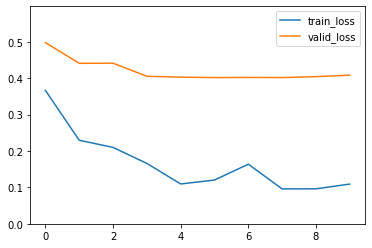

In [ ]:
fcn_model = simple_FCN()
fcn_model.apply(init_weights)

lr = 0.0001 # current best = lr only with 0.0001 / epoch 10
epoch = 10
criterion = nn.BCEWithLogitsLoss() # output should be logit, not sigmod
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                          step_size=5,
                                          gamma=0.1)

fcn_model = fcn_model.to('cuda:0')
val_output, val_target = train_binary(model = fcn_model,
                              lr = lr,
                              epoch = epoch,
                              criterion = criterion,
                              optimizer = optimizer, 
                              scheduler = scheduler, 
                              _train_generator = train_generator,
                              _valid_generator = valid_generator,
                              use_scheduler = True)

### 4-4. Result
결과값을 다음과 같이 확인할 수 있습니다.

precision = 모델이 True로 분류한 것 중 실제 True인 비율

$$ precision = {True\_positive \over True\_positive + False\_positive} $$

recall = 실제 Ture인 것 중에서 모델이 모델이 True라고 예측한 것의 비율

$$ recall = {True\_positive \over True\_positive + False\_negative} $$

F1 Score = Precision 과 Recall의 조화평균

$$ F1\_Score = 2 \times { precision \times recall \over precision + recall} $$

macro_avg = averaging the unweighted mean per label <br>
weighted_avg = averaging the support-weighted mean per label

In [ ]:
print(classification_report(val_target, val_output, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       0.79      0.98      0.87     17745
    abnormal       0.92      0.49      0.64      9186

    accuracy                           0.81     26931
   macro avg       0.85      0.73      0.75     26931
weighted avg       0.83      0.81      0.79     26931



## 5. Deep Learning model training - multiclass classification

두번째 예제로 multiclass classification (다중클래스분류) 을 수행해 보겠습니다.<br>
이진 분류보다는 조금 더 어려운 문제이므로 앞서 이진분류 모델의 FCN보다 조금 더 deep 한 Convolutaion Neural Network (CNN)을 사용합니다.<br>
앞서 3-1. 데이터셋 구축 과정에서 추출해둔 symbol을 활용합니다.<br>


### 5-1. Define dataloader
다중클래스분류 모델을 학습시키기 위한 `dataloader`를 정의합니다.<br>
기본적인 구조는 FCN을 이용한 binary classification 때와 매우 흡사하지만 CNN 모델에 맞게 input shape을 수정해주어야 합니다.<br>
CNN을 사용하기 위한 데이터에서는 input 이 (*batch_size, channel, length*)의 구조를 가져야 합니다.<br>
우리 데이터의 경우 *channel* 수는 1 입니다.<br>
<br>
또한 딥러닝은 행렬연산의 연속이기 때문에 symbol을 수치로 변환해주어야 합니다.<br>
각 symbol을 숫자 하나로 매칭시켜 dictionary를 만들고 변환해줍니다.

In [ ]:
# make class and idx dictionary for multiclass classification
target_classes = abnormal + ['N']
symbol_idx_dict = dict(zip(target_classes, np.arange(len(target_classes))))
idx_symbol_dict = {v: k for k, v in symbol_idx_dict.items()}
print(symbol_idx_dict)
print(idx_symbol_dict)

{'L': 0, 'R': 1, 'V': 2, '/': 3, 'A': 4, 'f': 5, 'F': 6, 'j': 7, 'a': 8, 'E': 9, 'J': 10, 'e': 11, 'S': 12, 'N': 13}
{0: 'L', 1: 'R', 2: 'V', 3: '/', 4: 'A', 5: 'f', 6: 'F', 7: 'j', 8: 'a', 9: 'E', 10: 'J', 11: 'e', 12: 'S', 13: 'N'}


In [ ]:
class MyEcgDataset_CNN_multiclass(Dataset):
    
    def __init__(self, data, labels, sym2idx):
        super().__init__()

        self._data = data
        
        self._data = np.expand_dims(self._data, axis=2)
        self.data = np.transpose(self._data, (0, 2, 1))
        
        self.labels = labels
        self.sym2idx = sym2idx
        self.encoded_label = np.array([self.sym2idx[lab] for lab in self.labels])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.encoded_label[idx]

In [ ]:
batch_size = 2000

train_dataset_cnn_multiclass = MyEcgDataset_CNN_multiclass(X_train, symbol_train, symbol_idx_dict)
valid_dataset_cnn_multiclass = MyEcgDataset_CNN_multiclass(X_valid, symbol_valid, symbol_idx_dict)

train_generator_cnn_multiclass = DataLoader(dataset=train_dataset_cnn_multiclass, batch_size=batch_size, shuffle=True)
valid_generator_cnn_multiclass = DataLoader(dataset=valid_dataset_cnn_multiclass, batch_size=batch_size, shuffle=False)

### 5-2. Define training function

다중클래스분류를 위한 학습 함수를 정의합니다.<br>
기본적인 구조는 FCN을 이용한 binary classification과 매우 흡사하지만 다중분류를 위해 모델의 output에 `softmax` 함수를 사용하도록 변경하고 validation시 `accuracy` 이외에 `auroc`도 함께 출력할 수 있도록 다소 수정하였습니다.<br>
마찬가지로 각 epoch 마다 validation 결과를 출력하고 전체 loss 변화를 plotting 합니다.

In [ ]:
def train_multiclass(model, lr, epoch, criterion, optimizer, scheduler, 
          _train_generator, _valid_generator, symbol_dict, use_scheduler = False):

    # for loss plotting
    train_loss_log = []
    valid_loss_log = []

    for epo in range(epoch):

        for step, (batch_X, batch_Y) in enumerate(_train_generator):
            model.zero_grad()
            batch_X = batch_X.to('cuda:0')
            batch_Y = batch_Y.to('cuda:0')

            model.train()
            output = model(batch_X.float())
            loss = criterion(output, torch.squeeze(batch_Y).long())
            loss.backward()
            optimizer.step()

            training_loss = loss.data.cpu().numpy().astype(float)

            if step % 50 == 0:
                print('[Epochs: ' + str(epo+1) + '  step: ' + str(step) + 
                      ']' + '  Train loss: {:.4f}'.format(training_loss))
        
        if use_scheduler:
            scheduler.step()
            
        # validation
        model.eval()
        valid_output = []
        valid_target = []
        valid_pred =[]

        for valid_x, valid_y in _valid_generator:
            valid_x = valid_x.to('cuda:0')
            
            val_out = model(valid_x.float())
            val_pred = F.log_softmax(val_out, dim=1)
            
            #val_pred = val_out.argmax(dim=1, keepdim=True)
            
            val_out = val_out.cpu().data.numpy().astype(float)
            val_pred = val_pred.cpu().data.numpy().astype(float)

            valid_output.extend(val_out)
            valid_target.extend(valid_y)
            valid_pred.extend(val_pred)

        valid_output_var = torch.from_numpy(np.array(valid_output)).float()
        valid_target_var = torch.from_numpy(np.array(valid_target)).float()
        valid_pred_var = torch.from_numpy(np.array(valid_pred)).float() 

        valid_loss = criterion(valid_output_var, torch.squeeze(valid_target_var).long())
        valid_output_np = valid_output_var.detach().numpy().round()
        valid_target_np = valid_target_var.detach().numpy().round()
        valid_pred_np = valid_pred_var.detach().numpy().round()

        validation_loss = valid_loss.data.cpu().numpy().astype(float)
        
        valid_label = valid_pred_var.argmax(dim=1)
        
        # binarize the label
        valid_target_np_binarized = label_binarize(valid_target_np, 
                                                   classes=list(symbol_dict.values()))
        fpr = {}
        tpr = {}
        thresh = {}
        roc_auc = {}
        for i in range(len(symbol_dict.values())):
            fpr[i], tpr[i], thresh[i] = roc_curve(valid_target_np_binarized[:, i], 
                                                  valid_pred_np[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        fpr['micro'], tpr['micro'], thresh['micro'] = roc_curve(valid_target_np_binarized.ravel(), 
                                                                valid_pred_np.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])        
        roc_score = roc_auc['micro']
        correct = (valid_label.long() == valid_target_var.long()).data.numpy().sum()
        accuracy = correct / len(valid_label)

        print('[Epoch {} ends --------------------------]'.format(epo + 1))
        print('Validation loss : {:.4f}  /  Accuracy : {:.3f}  / AUROC : {:.3f} \n'.format(
        valid_loss, accuracy * 100, roc_score))

        # for log plotting
        train_loss_log.append(training_loss)
        valid_loss_log.append(validation_loss)

    training_log_df = pd.DataFrame({'train_loss': train_loss_log, 
                                   'valid_loss': valid_loss_log})
    df_fig_loss = training_log_df.astype(float).plot(
        ylim=(0, max(training_log_df.train_loss.values) * 1.2))
    
    # make roc_curve data
    roc_curve_data = (fpr, tpr, thresh, roc_auc)
    
    return valid_pred_np, valid_target_np, roc_curve_data

### 5-3. Define Convolutional Neural Network
간단한 CNN 모델을 정의합니다.<br>
7개의 블록을 가지고 각 블록은 2개의 convolution layer와 residual path를 포함합니다.<br>
residual path는 추후 모델 학습을 수월하게 하는 역할을 합니다.<br>
channel size는 32로 하고 kernel size는 5로 합니다.<br>
예측을 위한 classifier는 32개의 neuron을 갖는 2개의 layer로 구성합니다.

In [ ]:
class CNN_multiclass(nn.Module):
    def __init__(self, input_size,num_classes):
        super(CNN_multiclass, self).__init__()
    
        self.conv= nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=5,stride=1)
        
        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5,stride=1,padding=2)
        self.drop_50 = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool1d(kernel_size=5,stride=2) 

        self.dense1 = nn.Linear(32 * 13, 32) 
        self.dense2 = nn.Linear(32, 32) 
        
        self.dense_final = nn.Linear(32, num_classes)
        self.softmax= nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        residual= self.conv(x)
      
        #block1 
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x+= residual 
        x = F.relu(x)
        residual = self.maxpool(x)
       
        #block2
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) 
        
        
        #block3
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) 
        
        
        #block4
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #131
        
        #block5
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #64
        
        #block6
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #30
        
        #block7
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        x= self.maxpool(x) #13

        
        #MLP
        x = x.view(-1, 32 * 13) # Reshape (current_dim, 32*13)
        x = F.relu(self.dense1(x))
        x = self.drop_50(x)
        x= self.dense2(x)
        x = self.dense_final(x)
        return x

### 5-4. Train model
모델을 학습시킵니다.<br>
앞서 정의한 CNN 네트워크를 선언하고 초기화합니다.<br>
학습을 위한 loss function은 `Cross Entropyloss`를 사용하고 optimizer는 `Adam`을 사용합니다.<br>
모델의 파라미터가 많아짐에 따라 학습시간이 좀 더 오래 걸릴 수 있습니다.

[Epochs: 1  step: 0]  Train loss: 11.3500
[Epoch 1 ends --------------------------]
Validation loss : 1.3808  /  Accuracy : 65.891  / AUROC : 0.898 

[Epochs: 2  step: 0]  Train loss: 1.4229
[Epoch 2 ends --------------------------]
Validation loss : 1.1519  /  Accuracy : 66.065  / AUROC : 0.940 

[Epochs: 3  step: 0]  Train loss: 1.1156
[Epoch 3 ends --------------------------]
Validation loss : 1.1199  /  Accuracy : 66.240  / AUROC : 0.954 

[Epochs: 4  step: 0]  Train loss: 0.9950
[Epoch 4 ends --------------------------]
Validation loss : 0.8911  /  Accuracy : 69.582  / AUROC : 0.965 

[Epochs: 5  step: 0]  Train loss: 0.8155
[Epoch 5 ends --------------------------]
Validation loss : 0.8656  /  Accuracy : 70.658  / AUROC : 0.969 

[Epochs: 6  step: 0]  Train loss: 0.7403
[Epoch 6 ends --------------------------]
Validation loss : 0.7874  /  Accuracy : 76.804  / AUROC : 0.972 

[Epochs: 7  step: 0]  Train loss: 0.7198
[Epoch 7 ends --------------------------]
Validation loss : 0.77

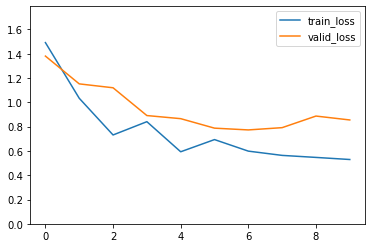

In [ ]:
cnn_model_multiclass = CNN_multiclass(input_size = 1, num_classes=len(symbol_idx_dict))
cnn_model_multiclass.apply(init_weights)

lr = 0.001
epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model_multiclass.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                          step_size=7,
                                          gamma=0.5)

cnn_model_multiclass = cnn_model_multiclass.to('cuda:0')
val_output, val_target, roc_curve_raw_data = train_multiclass(
                              model = cnn_model_multiclass,
                              lr = lr,
                              epoch = epoch,
                              criterion = criterion,
                              optimizer = optimizer, 
                              scheduler = scheduler, 
                              _train_generator = train_generator_cnn_multiclass,
                              _valid_generator = valid_generator_cnn_multiclass,
                              symbol_dict=symbol_idx_dict,
                              use_scheduler=True)

### 5-5. Result
클래스 별 roc curve를 다음과 같이 출력하여 성능을 확인할 수 있습니다.

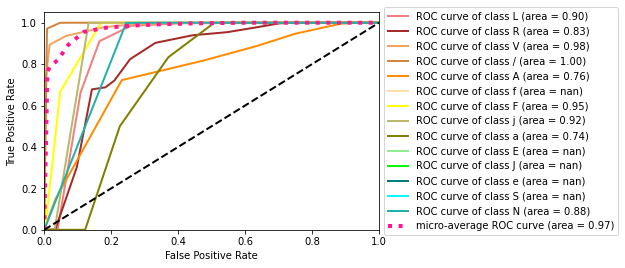

In [ ]:
plot_fpr, plot_tpr, plot_thresh, plot_roc_auc = roc_curve_raw_data
lw=2
# Plot all ROC curves
plt.figure()

colors = cycle(['lightcoral', 'brown', 'sandybrown',
                'peru', 'darkorange', 'navajowhite',
                'yellow', 'darkkhaki', 'olive', 
                'lightgreen', 'lime', 'teal',
                'aqua', 'lightseagreen', 'deepskyblue',
                'cornflowerblue', 'navy', 'slateblue', 
               'blueviolet', 'plum', 'pink'])

for i, ((symbol, symidx), color) in enumerate(zip(symbol_idx_dict.items(), colors)):
    plt.plot(plot_fpr[i], plot_tpr[i], color=color, lw=lw,
             label='ROC curve of class {} (area = {:.2f})'.format(str(symbol), plot_roc_auc[i]))
    
plt.plot(plot_fpr["micro"], plot_tpr["micro"],
     label='micro-average ROC curve (area = {0:0.2f})'
           ''.format(plot_roc_auc["micro"]),
     color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()